In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras import backend as K
from keras import Sequential, Input
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt

import math

from utils.load_dataset import load_dataset
from utils.constants import CLASSES, IMAGE_SIZE

In [16]:
# make the result reproducible
keras.utils.set_random_seed(42)

In [17]:
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [19]:
DIRPATH = './data'
X_train, X_test, y_train, y_test = load_dataset(DIRPATH)

## Building a model

Testing LeNet-5 Architecture

In [20]:
conv_regularizer = regularizers.l2(0.0009096443481619992)
dense_regularizer = regularizers.l2(0.011905583599301073)

# activation_def = 'tanh'

dropout_base = 0.09439855997376015
dropout_inc = 0.14131761625994724
dropout_1 = dropout_base
dropout_2 = dropout_base + dropout_inc
dropout_3 = dropout_base + 2*dropout_inc

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=5, padding="same", activation="tanh",
                        kernel_regularizer=conv_regularizer) # kernel_initializer="he_normal")

model = Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    DefaultConv2D(6),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(dropout_1),
    DefaultConv2D(16),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Dropout(dropout_2),
    DefaultConv2D(120),

    layers.Flatten(),
    layers.Dropout(dropout_3),
    DefaultConv2D(84),
    layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 16)         

In [21]:
optimizer = Adam(learning_rate=0.001)

def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
  return lr

lr_metric = get_lr_metric(optimizer)


# model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy", lr_metric])

In [22]:
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.5
  epochs_drop = 40.0
  lrate = initial_lrate * math.pow(drop,  
          math.floor((1+epoch)/epochs_drop))
  return lrate
 
lrate_scheduler_callback = LearningRateScheduler(step_decay)

## Training Preparation

In [23]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [24]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [25]:
%%time
batch_size = 200
epochs = 100

history = model.fit(
  X_train, y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  callbacks=[model_checkpoint_callback, lrate_scheduler_callback]
)

Epoch 1/100
22/22 [==============================] - 1s 28ms/step - loss: 4.9319 - accuracy: 0.0663 - val_loss: 4.2841 - val_accuracy: 0.1197
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 3.6980 - accuracy: 0.2222 - val_loss: 3.2366 - val_accuracy: 0.2797
Epoch 3/100
22/22 [==============================] - 0s 10ms/step - loss: 2.9385 - accuracy: 0.3487 - val_loss: 2.7531 - val_accuracy: 0.3647
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 2.5687 - accuracy: 0.4326 - val_loss: 2.4917 - val_accuracy: 0.4260
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 2.3683 - accuracy: 0.4787 - val_loss: 2.2455 - val_accuracy: 0.4991
Epoch 6/100
22/22 [==============================] - 0s 10ms/step - loss: 2.2025 - accuracy: 0.5206 - val_loss: 2.1267 - val_accuracy: 0.5439
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 2.0991 - accuracy: 0.5457 - val_loss: 2.0244 - val_accuracy: 0.5612
Epoch 8/

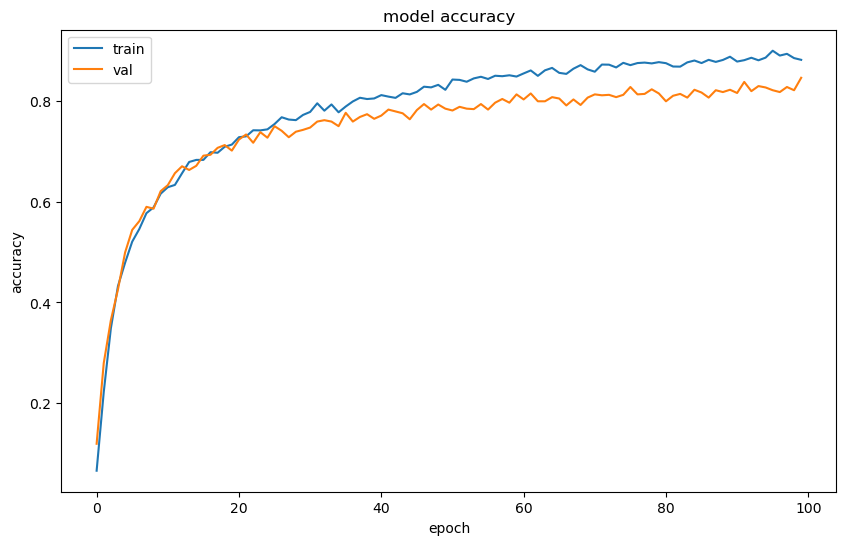

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
length = len(history.history['accuracy'])
print("train set accuracy:", round(history.history['accuracy'][length-1], 2))
print("validation set accuracy:", round(history.history['val_accuracy'][length-1], 2))

train set accuracy: 0.88
validation set accuracy: 0.85


In [28]:
# model.load_weights("models/checkpoints/famous48_test_model_v2_best.keras")
results = model.evaluate(X_test, y_test)
print("test set accuracy:", round(results[1], 2))

43/43 [==============================] - 0s 3ms/step - loss: 1.0548 - accuracy: 0.8208
test set accuracy: 0.82
